# Pair-wise Correlations

The purpose is to identify variables strongly correlated with the sales price and with each other to get an idea of what variables could be good predictors and potential issues with collinearity.

## "Housekeeping"

In [1]:
% load_ext watermark
% watermark -d -t -v -z -p matplotlib,numpy,pandas,seaborn

2018-09-02 23:23:32 CEST

CPython 3.6.5
IPython 6.5.0

matplotlib 3.0.0rc2
numpy 1.15.1
pandas 0.23.4
seaborn 0.9.0


In [2]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from utils import (
    CONTINUOUS_VARIABLES,
    DISCRETE_VARIABLES,
    NUMERIC_VARIABLES,
    ORDINAL_VARIABLES,
    TARGET_VARIABLE,
    load_clean_data,
    print_column_list,
)

In [3]:
% matplotlib inline

In [4]:
pd.set_option("display.max_columns", 100)

In [5]:
sns.set_style("white")

## Load the Data

A subset of the previously cleaned data is used in this analysis. It does not make sense to calculate correlations involving nominal variables.

In [6]:
df = load_clean_data(
    subset=CONTINUOUS_VARIABLES + DISCRETE_VARIABLES + ORDINAL_VARIABLES,
    ordinal_encoded=True,
)

In [7]:
df[NUMERIC_VARIABLES].head()

,,1st Flr SF,2nd Flr SF,3Ssn Porch,Bedroom AbvGr,Bsmt Full Bath,Bsmt Half Bath,Bsmt Unf SF,BsmtFin SF 1,BsmtFin SF 2,Enclosed Porch,Fireplaces,Full Bath,Garage Area,Garage Cars,Gr Liv Area,Half Bath,Kitchen AbvGr,Lot Area,Low Qual Fin SF,Mas Vnr Area,Misc Val,Mo Sold,Open Porch SF,Pool Area,Screen Porch,TotRms AbvGrd,Total Bsmt SF,Wood Deck SF,Year Built,Year Remod/Add,Yr Sold
Order,PID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,526301100,1656.0,0.0,0.0,3,1,0,441.0,639.0,0.0,0.0,2,1,528.0,2,1656.0,0,1,31770.0,0.0,112.0,0.0,5,62.0,0.0,0.0,7,1080.0,210.0,1960,1960,2010
2,526350040,896.0,0.0,0.0,2,0,0,270.0,468.0,144.0,0.0,0,1,730.0,1,896.0,0,1,11622.0,0.0,0.0,0.0,6,0.0,0.0,120.0,5,882.0,140.0,1961,1961,2010
3,526351010,1329.0,0.0,0.0,3,0,0,406.0,923.0,0.0,0.0,0,1,312.0,1,1329.0,1,1,14267.0,0.0,108.0,12500.0,6,36.0,0.0,0.0,6,1329.0,393.0,1958,1958,2010
4,526353030,2110.0,0.0,0.0,3,1,0,1045.0,1065.0,0.0,0.0,2,2,522.0,2,2110.0,1,1,11160.0,0.0,0.0,0.0,4,0.0,0.0,0.0,8,2110.0,0.0,1968,1968,2010
5,527105010,928.0,701.0,0.0,3,0,0,137.0,791.0,0.0,0.0,1,2,482.0,2,1629.0,1,1,13830.0,0.0,0.0,0.0,3,34.0,0.0,0.0,6,928.0,212.0,1997,1998,2010


Ordinal variables are encoded as integers (with greater values indicating a higher sales price by "guts feeling"; refer to the [data documentation](https://www.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt) to see the un-encoded values) and take part in the analysis.

In [8]:
df[ORDINAL_VARIABLES].head()

,,Bsmt Cond,Bsmt Exposure,Bsmt Qual,BsmtFin Type 1,BsmtFin Type 2,Electrical,Exter Cond,Exter Qual,Fence,Fireplace Qu,Functional,Garage Cond,Garage Finish,Garage Qual,Heating QC,Kitchen Qual,Land Slope,Lot Shape,Overall Cond,Overall Qual,Paved Drive,Pool QC,Utilities
Order,PID,,,,,,,,,,,,,,,,,,,,,,,
1,526301100,4,4,3,4,1,4,2,2,0,4,7,3,3,3,1,2,2,2,4,5,1,0,3
2,526350040,3,1,3,3,2,4,2,2,3,0,7,3,1,3,2,2,2,3,5,4,2,0,3
3,526351010,3,1,3,5,1,4,2,2,0,0,7,3,1,3,2,3,2,2,5,5,2,0,3
4,526353030,3,1,3,5,1,4,2,3,0,3,7,3,3,3,4,4,2,3,4,6,2,0,3
5,527105010,3,1,4,6,1,4,2,2,3,3,7,3,3,3,3,2,2,2,4,4,2,0,3


## Correlations

The pair-wise correlations are calculated based on the type of the variables:
- **continuous** variables are assumed to be linearly related with the target and each other or not: **Pearson's correlation coefficient**
- **discrete** (because of the low number of distinct realizations as seen in the data cleaning notebook) and **ordinal** (low number of distinct realizations as well) variables are assumed to be related in a monotonic way with the target and each other or not: **Spearman's rank correlation coefficient**

Furthermore, a "rule of thumb" classification in *weak* and *strong* correlation is applied to the variables. The identified variables will be used in the prediction modelling part to speed up the feature selection. A correlation between 0.33 and 0.66 is considered *weak* while a correlation above 0.66 is considered *strong*.

In [9]:
strong = 0.66
weak = 0.33

Two heatmaps below (implemented in the reusable `plot_correlation` function) help visualize the correlations.

Obviously, many variables are pair-wise correlated. This could yield regression coefficients *inprecise* and not usable / interpretable. At the same time, this does not lower the predictive power of a model as a whole. In contrast to the pair-wise correlations, *multi-collinearity* is not checked here.

In [10]:
def plot_correlation(data, title):
    """Visualize a correlation matrix in a nice heatmap."""
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_title(title, fontsize=24)
    # Blank out the upper triangular part of the matrix.
    mask = np.zeros_like(data, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Use a diverging color map.
    cmap = sns.diverging_palette(240, 0, as_cmap=True)
    # Adjust the labels' font size.
    labels = data.columns
    ax.set_xticklabels(labels, fontsize=10)
    ax.set_yticklabels(labels, fontsize=10)
    # Plot it.
    sns.heatmap(
        data, vmin=-1, vmax=1, cmap=cmap, center=0, linewidths=.5,
        cbar_kws={"shrink": .5}, square=True, mask=mask, ax=ax
    )

### Pearson

Pearson's correlation coefficient shows a linear relationship between two variables.

In [11]:
pearson = df[CONTINUOUS_VARIABLES + TARGET_VARIABLE].corr(method="pearson")

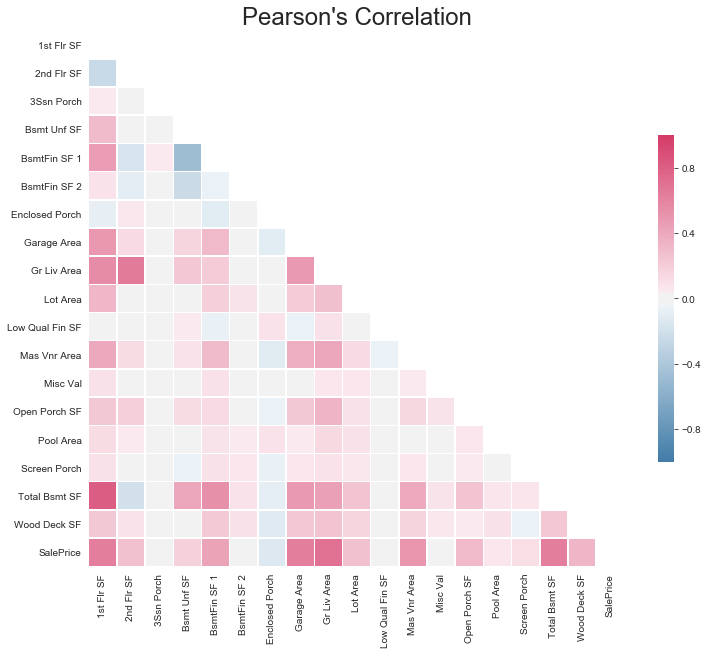

In [12]:
plot_correlation(pearson, "Pearson's Correlation")

In [13]:
corrs = pearson.loc['SalePrice'].drop('SalePrice')

Show the continuous variables that are weakly and strongly correlated with the sales price.

In [14]:
pearson_weakly_correlated = list(corrs[(weak < corrs) & (corrs <= strong)].index)
print_column_list(pearson_weakly_correlated)

1st Flr SF     First Floor square feet
BsmtFin SF 1   Type 1 finished square feet
Garage Area    Size of garage in square feet
Mas Vnr Area   Masonry veneer area in square feet
Total Bsmt SF  Total square feet of basement area


In [15]:
pearson_strongly_correlated = list(corrs[(strong < corrs)].index)
print_column_list(pearson_strongly_correlated)

Gr Liv Area  Above grade (ground) living area square feet


### Spearman

Spearman's correlation coefficient shows an ordinal rank relationship between two variables.

In [16]:
spearman = df[sorted(DISCRETE_VARIABLES + ORDINAL_VARIABLES) + TARGET_VARIABLE].corr(method="spearman")

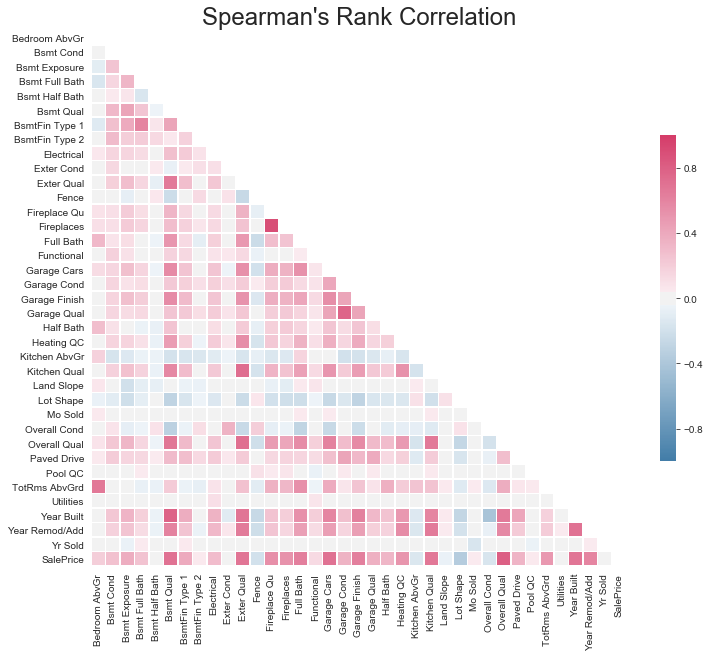

In [17]:
plot_correlation(spearman, "Spearman's Rank Correlation")

In [18]:
corrs = spearman.loc['SalePrice'].drop('SalePrice')

Show the discrete and ordinal variables that are weakly and strongly correlated with the sales price.

In [19]:
spearman_weakly_correlated = list(corrs[(weak < corrs) & (corrs <= strong)].index)
print_column_list(spearman_weakly_correlated)

Bsmt Exposure   Refers to walkout or garden level walls
BsmtFin Type 1  Rating of basement finished area
Fireplace Qu    Fireplace quality
Fireplaces      Number of fireplaces
Full Bath       Full bathrooms above grade
Garage Cond     Garage condition
Garage Finish   Interior finish of the garage
Garage Qual     Garage quality
Half Bath       Half baths above grade
Heating QC      Heating quality and condition
Paved Drive     Paved driveway
TotRms AbvGrd   Total rooms above grade (does not include bathrooms)
Year Remod/Add  Remodel date (same as construction date if no remodeling or additions)


In [20]:
spearman_strongly_correlated = list(corrs[(strong < corrs)].index)
print_column_list(spearman_strongly_correlated)

Bsmt Qual     Evaluates the height of the basement
Exter Qual    Evaluates the quality of the material on the exterior
Garage Cars   Size of garage in car capacity
Kitchen Qual  Kitchen quality
Overall Qual  Rates the overall material and finish of the house
Year Built    Original construction date


### Save the weakly and strongly correlated Variables

In [21]:
with open("weakly_and_strongly_correlated_variables.json", "w") as file:
    file.write(json.dumps({
        "weakly_correlated": sorted(
            pearson_weakly_correlated + spearman_weakly_correlated
        ),
        "strongly_correlated": sorted(
            pearson_strongly_correlated + spearman_strongly_correlated
        ),
    }))